In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import os,sys
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline  

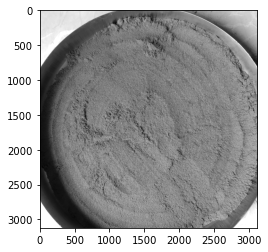

In [2]:
img = cv2.imread('10_per_adul/IMG_20210201_132826.jpg')
image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

In [3]:
def crop_photo_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=1)
    thresh = cv2.dilate(thresh, None, iterations=1)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Step 6:Cropped Image')
        
        plt.show()
    
    return new_image

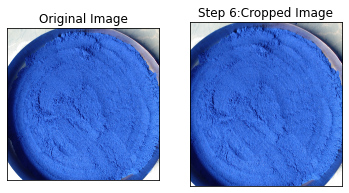

In [4]:
ex_img = cv2.imread('10_per_adul/IMG_20210201_132826.jpg')
ex_new_img = crop_photo_contour(ex_img,True)

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(os.path.join(directory,filename))
            # load the image
            # crop the photo and ignore the unnecessary rest part of the image
            #image = crop_photo_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array
            if directory == '10_per_adul':
                y.append([1])
            elif directory == '15_per_adul':
                y.append([2])
            elif directory == '20_per_adul':
                y.append([3])
            elif directory == '25_per_adul':
                y.append([4])
            elif directory == '30_per_adul':
                y.append([5])
            elif directory == 'pure':
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
      
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
ten_per = '10_per_adul'
fifteen_per= '15_per_adul'
twenty_per= '20_per_adul'
twentyfive_per= '25_per_adul'
thirty_per= '30_per_adul'
pure= 'pure'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([ten_per,fifteen_per,twenty_per,twentyfive_per,thirty_per,pure], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 343
X shape is: (343, 224, 224, 3)
y shape is: (343, 1)


In [7]:
def plot_sample_images(X, y, n=5):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1,2,3,4,5]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        if (label == 1):
            label_to_str="10_per_adultered"
        elif (label==2):
            label_to_str="15_per_adultered"
        elif (label==3):
            label_to_str="20_per_adultered"
        elif (label==4):
            label_to_str="25_per_adultered"
        elif (label==5):
            label_to_str="30_per_adultered"
        else:
            label_to_str="pure"
            
        
        plt.suptitle(f"Red chilli powder: {label_to_str}")
        plt.show()

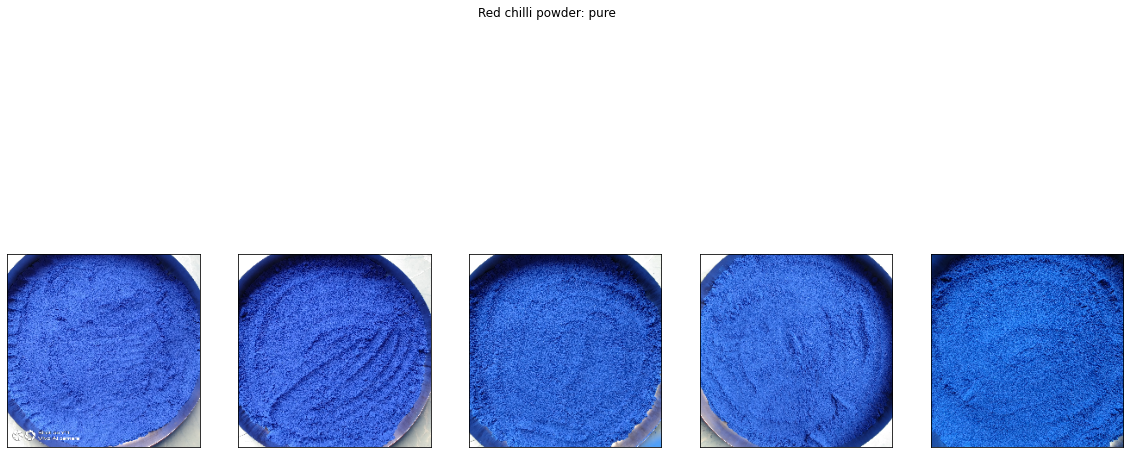

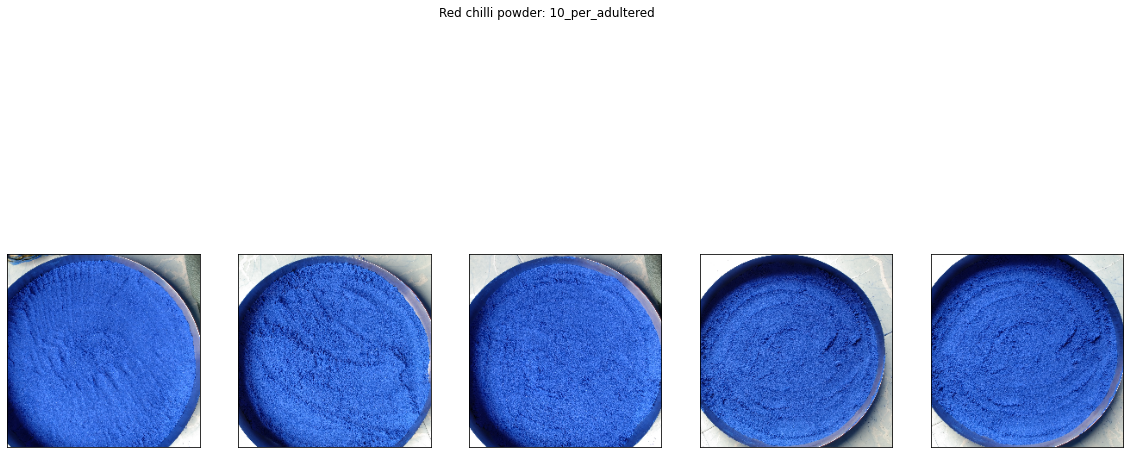

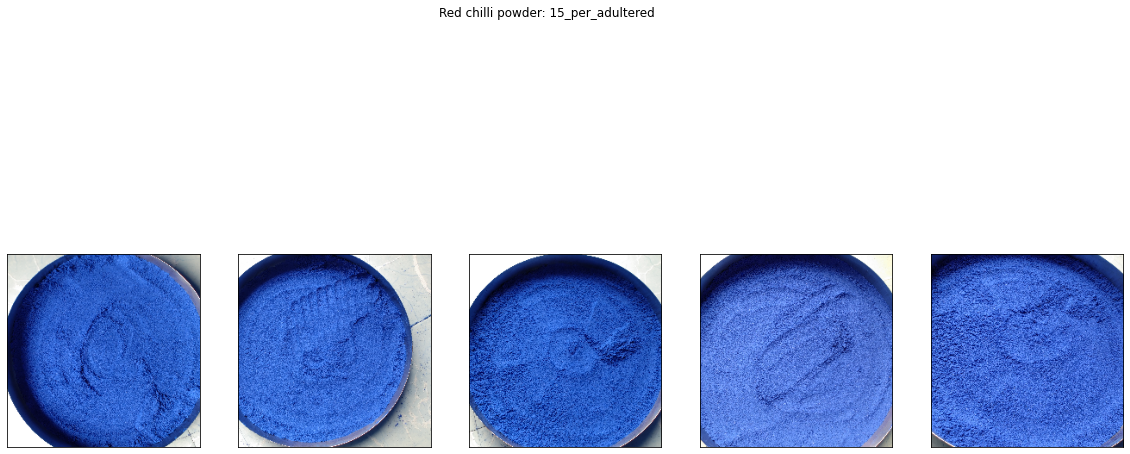

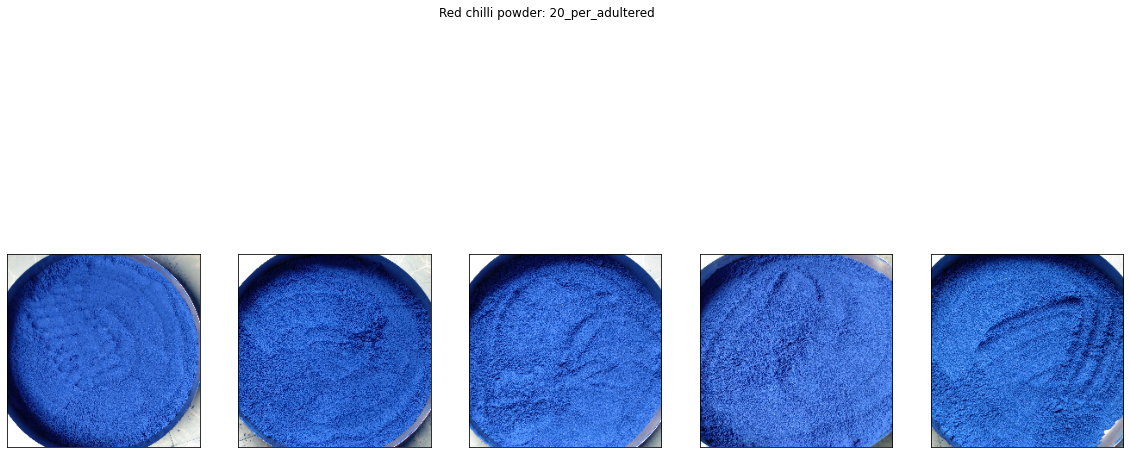

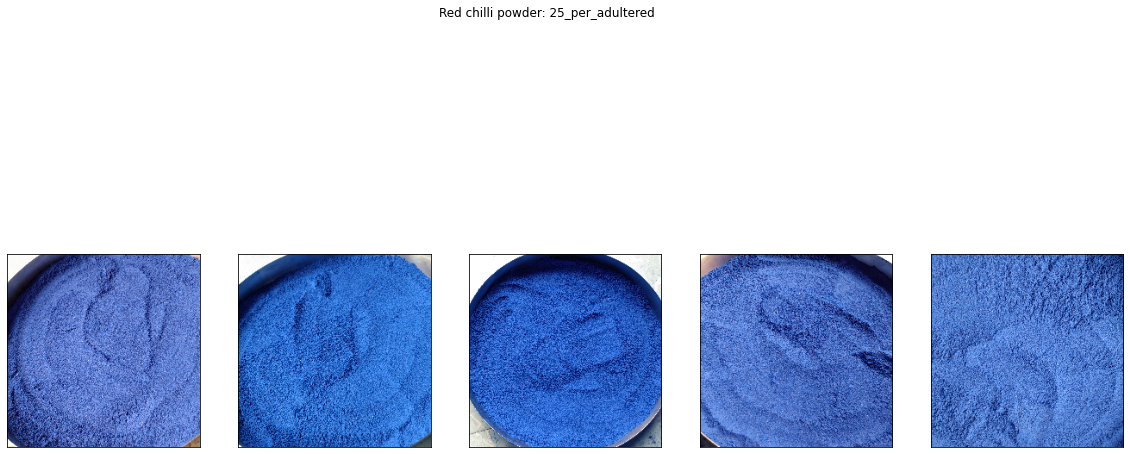

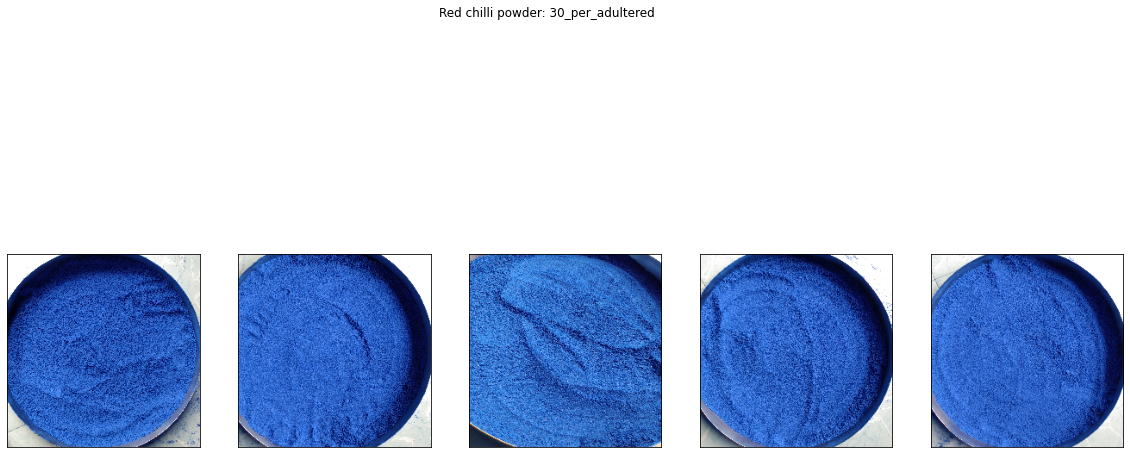

In [8]:
plot_sample_images(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 274
number of test examples = 69
X_train shape: (274, 224, 224, 3)
Y_train shape: (274, 1)
X_test shape: (69, 224, 224, 3)
Y_test shape: (69, 1)


In [11]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

In [13]:
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=1000, activation="relu"))
model.add(Dense(units=6, activation="softmax"))

In [14]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Abhishek\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [16]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [17]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [18]:
#tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
#tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')
early=EarlyStopping(monitor='val_accuracy',min_delta=0,patience=25,verbose=1,mode='auto')

In [19]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto'))

In [20]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=8, epochs=22, validation_data=(X_test, y_test), callbacks=[early, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/22
35/35 [==============================] - 254s 7s/step - loss: 1.7922 - accuracy: 0.1642 - val_loss: 1.7916 - val_accuracy: 0.1449
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.14.model\assets
Epoch 2/22
35/35 [==============================] - 261s 7s/step - loss: 1.7916 - accuracy: 0.1752 - val_loss: 1.7909 - val_accuracy: 0.2174
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.22.model\assets
Epoch 3/22
35/35 [==============================] - 262s 8s/step - loss: 1.7912 - accuracy: 0.1861 - val_loss: 1.7903 - val_accuracy: 0.2464
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.25.model\assets
Epoch 4/22
35/35 [==============================] - 264s 8s/step - loss: 1.7924 - accuracy: 0.1934 - val_loss: 1.7904 - val_accuracy: 0.1739
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.17.model\assets
Epoch 5/22
35/35 [==============================] - 265s 8s/step - loss: 1.7

In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=8, epochs=10, validation_data=(X_test, y_test), callbacks=[early, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
35/35 [==============================] - 253s 7s/step - loss: 0.5189 - accuracy: 0.8102 - val_loss: 1.1758 - val_accuracy: 0.6087
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.61.model\assets
Epoch 2/10
35/35 [==============================] - 263s 8s/step - loss: 0.5056 - accuracy: 0.8066 - val_loss: 0.9988 - val_accuracy: 0.6522
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.65.model\assets
Epoch 3/10
35/35 [==============================] - 270s 8s/step - loss: 0.5012 - accuracy: 0.8102 - val_loss: 0.8036 - val_accuracy: 0.7246
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.72.model\assets
Epoch 4/10
35/35 [==============================] - 267s 8s/step - loss: 0.2738 - accuracy: 0.8978 - val_loss: 0.9791 - val_accuracy: 0.6957
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.70.model\assets
Epoch 5/10
35/35 [==============================] - 262s 8s/step - loss: 0.2

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=8, epochs=7, validation_data=(X_test, y_test), callbacks=[early, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/7
35/35 [==============================] - 248s 7s/step - loss: 0.0385 - accuracy: 0.9927 - val_loss: 0.9573 - val_accuracy: 0.7826
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.78.model\assets
Epoch 2/7
35/35 [==============================] - 258s 7s/step - loss: 0.0206 - accuracy: 0.9964 - val_loss: 1.1983 - val_accuracy: 0.7971
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.80.model\assets
Epoch 3/7
35/35 [==============================] - 261s 7s/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 1.0346 - val_accuracy: 0.7826
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.78.model\assets
Epoch 4/7
35/35 [==============================] - 263s 8s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.0443 - val_accuracy: 0.7826
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.78.model\assets
Epoch 5/7
35/35 [==============================] - 267s 8s/step - loss: 0.0038 -

In [23]:
model.save('VGGmodel1.h5')

In [24]:
history = model.history.history

In [25]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [26]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

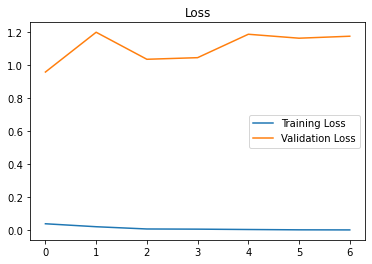

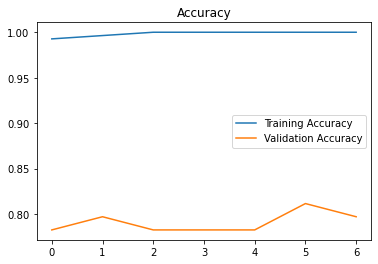

In [27]:
plot_metrics(history)